# A worked Machine Learning example
In this notebook, we'll look at a worked example for examining a dataset and creating a predictive model, or ensemble of models, to predict the output for new data points.

We will use the output of the FizzBuzz program and 'reverse engineer' the program using data analysis and machine learning. So, in the end, our model should be capable of predicting the output of the FizzBuzz program for a given input.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pandas as pd
import seaborn as sns
from pyspark.mllib.tree import LabeledPoint, RandomForest, RandomForestModel
from pyspark.mllib.regression import LinearRegressionWithSGD, RidgeRegressionWithSGD

## Load and parse data

In [3]:
rdd = (
    sc
    .textFile('fizzbuzz.csv')                     # read textfile
    .map(lambda line: line.strip().split(','))    # parse CSV into two fields
    .map(lambda (n, fb): (int(n), fb))            # parse first element as int
)

## Data overview
It is generally a good idea to get a count for your dataset, so you know that it loaded properly and that there are no obvious errors at first sight. Secondly, you'll want to just eyeball the data to have a look at the values in there and get a better feeling for what different columns might mean.

In [4]:
rdd.count()

200000

In [5]:
rdd.take(20)

[(1, u'1'),
 (2, u'2'),
 (3, u'Fizz'),
 (4, u'4'),
 (5, u'Buzz'),
 (6, u'Fizz'),
 (7, u'7'),
 (8, u'8'),
 (9, u'Fizz'),
 (10, u'Buzz'),
 (11, u'11'),
 (12, u'Fizz'),
 (13, u'13'),
 (14, u'14'),
 (15, u'FizzBuzz'),
 (16, u'16'),
 (17, u'17'),
 (18, u'Fizz'),
 (19, u'19'),
 (20, u'Buzz')]

## Numbers vs. the rest
In this example, the target is to predict the second column of the data (fizzbuzz) based on the first (the number input). It appears that the output is a string which can either be a number or some label, usually Fizz, Buzz or FizzBuzz. Let us verify that this is the case. We'll split the data into two parts based on the output:
- the numbers
- the rest (textual output)

Using this split and subsequent analysis, we might gain insight into what causes the output to be either a number or something else.

In [6]:
def is_int(x):
    try:
        int(x)
        return True
    except:
        return False

In [7]:
not_numbers = rdd.filter(lambda (n, fb): not is_int(fb)) # Filter only values that are not an int
not_numbers.take(20)

[(3, u'Fizz'),
 (5, u'Buzz'),
 (6, u'Fizz'),
 (9, u'Fizz'),
 (10, u'Buzz'),
 (12, u'Fizz'),
 (15, u'FizzBuzz'),
 (18, u'Fizz'),
 (20, u'Buzz'),
 (21, u'Fizz'),
 (24, u'Fizz'),
 (25, u'Buzz'),
 (27, u'Fizz'),
 (30, u'FizzBuzz'),
 (33, u'Fizz'),
 (35, u'Buzz'),
 (36, u'Fizz'),
 (39, u'Fizz'),
 (40, u'Buzz'),
 (42, u'Fizz')]

## Fizz, Buzz, FizzBuzz
It once more appears that all the non-numerical output is either Fizz, Buzz or FizzBuzz and nothing else. Here we verify this and also, we create a count for how often each of these occur. When working with a large dataset, we should always be careful when creating histograms like these and collectin them locally; there could be a very high cardinality and the result might be too large to collect locally in memory. Hence, we first do a count.

In [8]:
not_numbers_hist = (
    not_numbers
    .map(lambda (n, fb): (fb, 1))       # Create tuples of (value, 1)
    .reduceByKey(lambda x,y: x + y)     # Group by value and sum the 1's
)
not_numbers_hist.count()                # Find out how many classes there are

3

In [9]:
not_numbers_hist.collect()              # Since there are only three classes, it's safe to collect

[(u'FizzBuzz', 13333), (u'Fizz', 53333), (u'Buzz', 26667)]

## 5 and 3 look important
In the sample above with all the fizzes and buzzes, the apparent situation is that all input numbers that results in a text label are divisible by 3 or 5. We will try incorporate this idea into the model that we train, by performing feature engineering: we create derived features from the original input feature. In this case, we will add a boolean feature that is True when the input is divisible by 3 and False otherwise. We do the same for 5.

Note that at this point we do not verify whether our assumption about 3 and 5 are completely and always correct. Instead, we will just train the model with it and look at the evaluation results. If there is a relation as we assumed, the model will learn about it and the evaluation will show a low error value; otherwise, it's back to the drawing board.

In [10]:
# We create a DataFrame from a sample of the RDD of not_numbers
not_number_frame = pd.DataFrame(
    not_numbers
    .sample(False, 0.01, 0)                # 1% sample
    .map(lambda (n, fb): {                 # Turn into a collection of dict's
        'n': n,
        'fizzbuzz': fb,
        'by_three': n % 3 == 0,            # Include engineered feature for divisibility by three
        'by_five': n % 5 == 0              # Include engineered feature for divisibility by five
        }).collect()                       # Collect the sample locally into the DataFrame
)

In [11]:
# Let's have a look
not_number_frame.head()

,by_five,by_three,fizzbuzz,n
0,False,True,Fizz,66
1,True,False,Buzz,380
2,False,True,Fizz,462
3,True,False,Buzz,550
4,True,True,FizzBuzz,645


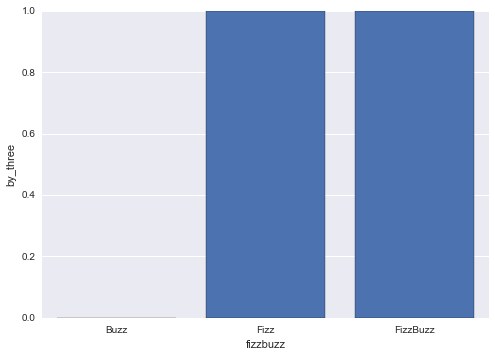

In [12]:
# What is the relation between divisibility by three and the outcome (in case of not a number)
sns.barplot(not_number_frame.fizzbuzz, not_number_frame.by_three)

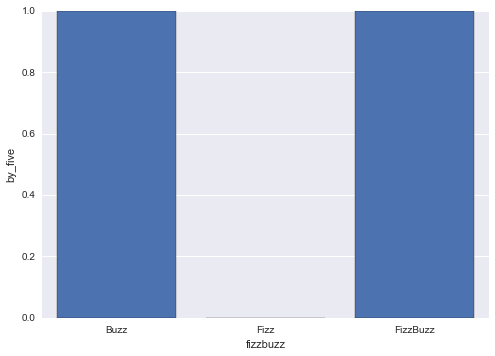

In [13]:
# Same for five
sns.barplot(not_number_frame.fizzbuzz, not_number_frame.by_five)

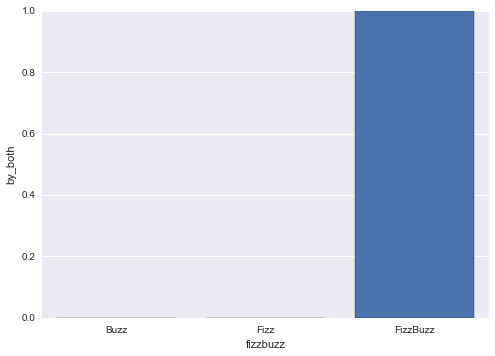

In [14]:
# Same for divisibility by both
not_number_frame['by_both'] = not_number_frame.by_three & not_number_frame.by_five
sns.barplot(not_number_frame.fizzbuzz, not_number_frame.by_both)

## Decisions and numbers
The three plot above show the normalized frequency of the label outputs (Fizz, Buzz or FizzBuzz) given the divisibility by either 3, 5 or both. What we see is that for different truths for divisibility by 3 and 5, there's a hard decision boundary between different label values. This type of realtion should be effectively learned by decision trees.

What remains is the part of the data where the result is not a label, but a numeric value. Let's further investigate.

In [15]:
numbers = (
    rdd
    .filter(lambda (n, fb): is_int(fb))            # Filter only numbers (int's)
    .map(lambda (n, fb): (n, int(fb)))             # Parse the string into an int if it is one
)

numbers_frame = pd.DataFrame(
    numbers.sample(False, 0.01, 0).collect(),      # Take a 1% sample
    columns=['n', 'fizzbuzz'])                     # Name the columns

numbers_frame.head(10)

,n,fizzbuzz
0,58,58
1,331,331
2,404,404
3,481,481
4,563,563
5,736,736
6,923,923
7,943,943
8,1076,1076
9,1081,1081


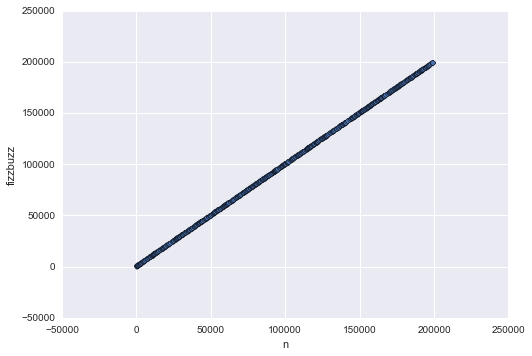

In [16]:
# Let's look at the relation between n and the outcome
numbers_frame.plot(kind='scatter', x='n', y='fizzbuzz')

## Linearity
The relation between the input and output in the case of numbers appears perfectly linear (who would have thought?). This part of the data is probably better described by a regression model.

## Modelling
We conclude from the above analysis, that we can handle this prediction problem with a combination of two models using the following approach.

For training:
- Train a classification model (based on decision trees) on the part of the data with non-numeric output.
- Train a regression model on the part of the data with numeric output.

For prediction:
- Make a prediction for the type of output (a textual label or numeric) using the classification model.
- If the classification model predicts a label, predict that.
- If the classification model predicts a numeric output, use the regression model to predict the value.

We will train both models and evaluate both models using a train/test split of the data.

### Classification
We start out with the classification model. Here we use a Random Forest classification model.

In [17]:
def fizzbuzz_type(fb):
    # Spark MLLib requires to encode everything into floats, even classes
    return {
        'Fizz': 1.0,
        'Buzz': 2.0,
        'FizzBuzz': 3.0
    }.get(fb, 0.0)

classifier_points = rdd.map(lambda (n, fb): LabeledPoint(fizzbuzz_type(fb), [n, n % 3 == 0, n % 5 == 0]))
classifier_points_train, classifier_points_test = classifier_points.randomSplit([0.6, 0.4])

In [18]:
classifier_model = RandomForest.trainClassifier(
    classifier_points_train,                  # Use only the training part of the data
    numClasses=4,                             # We can predict one of four classes
    categoricalFeaturesInfo={1: 2, 2: 2},     # RandomForest needs to know which features are categorical
    numTrees=3,
    featureSubsetStrategy="auto",
    impurity='gini',
    maxDepth=4,
    maxBins=32)

classifier_model

TreeEnsembleModel classifier with 3 trees

### Regression model
For the linear regression we use a linear regression with SGD.

In [19]:
regression_points = numbers.map(lambda (n, fb): LabeledPoint(fb, [n]))
regression_points_train, regression_points_test = regression_points.randomSplit([0.6, 0.4])

In [20]:
regression_model = LinearRegressionWithSGD.train(
    regression_points_train,   # Use only the training part of the data
    iterations=100,
    step=1.0,
    initialWeights=[1.0]       # Little cheating here, but otherwise it won't converge on perfectly linear data.
)

regression_model

(weights=[1.0], intercept=0.0)

### Model evaluation
We will evaluate the two trained models separately. The final model should normally also be evaluated for fitness, but this is left as an exercise to the reader.

We will use the [Mean Squared Error](https://en.wikipedia.org/wiki/Mean_squared_error) as evaluation metric. A perfect prediction would yield an error of 0.0.

In [21]:
# Calculate the Mean Squared Error between an RDD of predictions and an RDD of LabeledPoints with actuals.
def MSE(predictions, test_data):
    values_and_preds = test_data.map(lambda p: p.label).zip(predictions)
    return values_and_preds.map(lambda (v, p): (v - p)**2).reduce(lambda x, y: x + y) / values_and_preds.count()

### Classification MSE

In [22]:
MSE(
    classifier_model.predict(
        classifier_points_test.map(lambda p: p.features)),
    classifier_points_test)

0.0

### Regression MSE

In [23]:
MSE(
    regression_points_test.map(lambda p: p.features)
                          .map(regression_model.predict),
    regression_points_test)

0.0

## Prediction function
Here we combine the two models as described.

In [24]:
def predict(n):
    classifier_features = [n, n % 3 == 0, n % 5 == 0]   # Features required by the classifier
    regression_features = [x]                           # Features required by the regression
    
    # This is required to translate the floating point labels back to the original,
    # since Spark requires floating point values as class labels.
    classes = {
        1.0: 'Fizz',
        2.0: 'Buzz',
        3.0: 'FizzBuzz'
    }
    
    return classes.get(
        classifier_model.predict(classifier_features),  # If the classifier gave us a textual output, use that
        regression_model.predict(regression_features))  # Otherwise, use the regression model's prediction

## Final predictions
Congratulations! We've machine learned FizzBuzz!

In [25]:
[ predict(x) for x in range(1,22) ]

[1.0,
 2.0,
 'Fizz',
 4.0,
 'Buzz',
 'Fizz',
 7.0,
 8.0,
 'Fizz',
 'Buzz',
 11.0,
 'Fizz',
 13.0,
 14.0,
 'FizzBuzz',
 16.0,
 17.0,
 'Fizz',
 19.0,
 'Buzz',
 'Fizz']